In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
import pulse_compiler_helper_fns

In [4]:
q.IBMQ.load_account() # Load account from disk
q.IBMQ.providers()    # List all available providers

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-internal', group='reservations', project='reservations')>,
 <AccountProvider for IBMQ(hub='ibm-q-dev', group='qiskit-terra', project='pulse-testing')>,
 <AccountProvider for IBMQ(hub='ibm-q-dev', group='qiskit', project='terra')>,
 <AccountProvider for IBMQ(hub='ibm-q-dev', group='support', project='new-device-test')>,
 <AccountProvider for IBMQ(hub='ibm-q-dev', group='cloud', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-perf', group='performance', project='default-params')>,
 <AccountProvider for IBMQ(hub='ibm-q-perf', group='performance', project='pulse-testing')>,
 <AccountProvider for IBMQ(hub='ibm-q-perf', group='qcaas', project='default')>,
 <AccountProvider for IBMQ(hub='perf-on-client-d', group='rocket', project='asplos')>]

In [5]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
system = q.pulse.PulseChannelSpec.from_backend(backend)
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [6]:
# Measure X on target
x_schedules = []
for theta in np.linspace(0, np.pi, 41, endpoint=True):
    schedule = pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system)
    schedule |= cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule |= measure << schedule.duration
    x_schedules.append(schedule)
    
# do same thing, but first flip 
for theta in np.linspace(0, np.pi, 41, endpoint=True):
    schedule = cmd_def.get('x', qubits=[0])
    schedule |= pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system) << schedule.duration
    schedule |= cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule |= measure << schedule.duration
    x_schedules.append(schedule)

In [7]:
# Measure Y on target
y_schedules = []
for theta in np.linspace(0, np.pi, 41, endpoint=True):
    schedule = pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system)
    schedule |= cmd_def.get('u1', qubits=[1], P0=-np.pi/2) << schedule.duration
    schedule |= cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule |= measure << schedule.duration
    y_schedules.append(schedule)
    
# do same thing, but first flip 
for theta in np.linspace(0, np.pi, 41, endpoint=True):
    schedule = cmd_def.get('x', qubits=[0])
    schedule |= pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system) << schedule.duration
    schedule |= cmd_def.get('u1', qubits=[1], P0=-np.pi/2) << schedule.duration
    schedule |= cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule |= measure << schedule.duration
    y_schedules.append(schedule)

In [8]:
# Measure Z on target
z_schedules = []
for theta in np.linspace(0, np.pi, 41, endpoint=True):
    schedule = pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system)
    schedule |= measure << schedule.duration
    z_schedules.append(schedule)
    
# do same thing, but first flip 
for theta in np.linspace(0, np.pi, 41, endpoint=True):
    schedule = cmd_def.get('x', qubits=[0])
    schedule |= pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system) << schedule.duration
    schedule |= measure << schedule.duration
    z_schedules.append(schedule)

In [9]:
shots = 1000
x_job = q.execute(x_schedules, backend=backend, shots=shots)
print('X job is %s' % x_job.job_id())

y_job = q.execute(y_schedules, backend=backend, shots=shots)
print('Y job is %s' % y_job.job_id())

z_job = q.execute(z_schedules, backend=backend, shots=shots)
print('Z job is %s' % z_job.job_id())

/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


X job is 5dd816a28aa7e00018b8f567
Y job is 5dd816bff5613200186ad323
Z job is 5dd816d90bf24b0018b73638


In [10]:
z_job.status()

<JobStatus.VALIDATING: 'job is being validated'>

In [11]:
backend.status()

BackendStatus(backend_name='alt_almaden', backend_version='1.2.4', operational=True, pending_jobs=3, status_msg='active')

In [12]:
x_result = x_job.result()
y_result = y_job.result()
z_result = z_job.result()

In [13]:
from qiskit.ignis.verification.tomography.data import marginal_counts

In [37]:
x_vals_control_off = []
for i in range(41):
    x_counts = marginal_counts(x_result.get_counts(i), meas_qubits=[1])
    x_vals_control_off.append((x_counts.get('0', 0) / shots - 0.5) * 2)

x_vals_control_on = []
for i in range(41, 82):
    x_counts = marginal_counts(x_result.get_counts(i), meas_qubits=[1])
    x_vals_control_on.append((x_counts.get('0', 0) / shots - 0.5) * 2)

print(x_vals_control_off)
print(x_vals_control_on)

[0.0020000000000000018, -0.02400000000000002, 0.03600000000000003, 0.028000000000000025, 0.02400000000000002, 0.06800000000000006, 0.07800000000000007, 0.016000000000000014, 0.04400000000000004, 0.0, 0.1319999999999999, 0.10200000000000009, 0.08000000000000007, 0.06600000000000006, 0.040000000000000036, 0.08200000000000007, 0.040000000000000036, 0.10400000000000009, 0.07800000000000007, 0.014000000000000012, 0.050000000000000044, -0.020000000000000018, 0.008000000000000007, 0.030000000000000027, 0.08400000000000007, 0.006000000000000005, 0.06400000000000006, 0.04200000000000004, 0.07800000000000007, 0.07800000000000007, 0.06000000000000005, 0.06000000000000005, 0.028000000000000025, 0.1200000000000001, 0.01200000000000001, 0.050000000000000044, 0.03400000000000003, 0.062000000000000055, -0.0020000000000000018, -0.0020000000000000018, -0.05600000000000005]
[0.028000000000000025, 0.05400000000000005, 0.04200000000000004, -0.020000000000000018, 0.0, 0.05600000000000005, 0.0, 0.08600000000

In [38]:
y_vals_control_off = []
for i in range(41):
    y_counts = marginal_counts(y_result.get_counts(i), meas_qubits=[1])
    y_vals_control_off.append((y_counts.get('0', 0) / shots - 0.5) * 2)

y_vals_control_on = []
for i in range(41, 82):
    y_counts = marginal_counts(y_result.get_counts(i), meas_qubits=[1])
    y_vals_control_on.append((y_counts.get('0', 0) / shots - 0.5) * 2)

print(y_vals_control_off)
print(y_vals_control_on)

[0.1259999999999999, 0.04400000000000004, -0.03400000000000003, -0.15800000000000003, -0.21599999999999997, -0.20799999999999996, -0.29800000000000004, -0.33799999999999997, -0.358, -0.43999999999999995, -0.516, -0.5760000000000001, -0.5660000000000001, -0.652, -0.6619999999999999, -0.6619999999999999, -0.74, -0.74, -0.748, -0.766, -0.764, -0.768, -0.742, -0.786, -0.764, -0.748, -0.716, -0.712, -0.6819999999999999, -0.65, -0.612, -0.548, -0.482, -0.496, -0.44199999999999995, -0.394, -0.378, -0.28, -0.21599999999999997, -0.21599999999999997, -0.052000000000000046]
[0.21199999999999997, 0.28600000000000003, 0.3400000000000001, 0.45599999999999996, 0.494, 0.5940000000000001, 0.6120000000000001, 0.6000000000000001, 0.712, 0.7, 0.774, 0.784, 0.8520000000000001, 0.8680000000000001, 0.8620000000000001, 0.8899999999999999, 0.8979999999999999, 0.948, 0.9019999999999999, 0.9099999999999999, 0.9179999999999999, 0.9319999999999999, 0.8819999999999999, 0.8440000000000001, 0.8620000000000001, 0.8540

In [39]:
z_vals_control_off = []
for i in range(41):
    z_counts = marginal_counts(z_result.get_counts(i), meas_qubits=[1])
    z_vals_control_off.append((z_counts.get('0', 0) / shots - 0.5) * 2)

z_vals_control_on = []
for i in range(41, 82):
    z_counts = marginal_counts(z_result.get_counts(i), meas_qubits=[1])
    z_vals_control_on.append((z_counts.get('0', 0) / shots - 0.5) * 2)

print(z_vals_control_off)
print(z_vals_control_on)

[0.972, 0.972, 0.968, 0.944, 0.9139999999999999, 0.8999999999999999, 0.8420000000000001, 0.8, 0.772, 0.782, 0.698, 0.5980000000000001, 0.6100000000000001, 0.5640000000000001, 0.558, 0.44199999999999995, 0.3779999999999999, 0.3700000000000001, 0.246, 0.20799999999999996, 0.18599999999999994, 0.05800000000000005, 0.02400000000000002, -0.09199999999999997, -0.132, -0.21599999999999997, -0.18999999999999995, -0.31200000000000006, -0.35, -0.372, -0.46199999999999997, -0.482, -0.5680000000000001, -0.558, -0.6719999999999999, -0.6719999999999999, -0.6599999999999999, -0.714, -0.728, -0.794, -0.84]
[0.966, 0.952, 0.944, 0.8999999999999999, 0.8779999999999999, 0.806, 0.764, 0.744, 0.736, 0.6599999999999999, 0.6339999999999999, 0.5720000000000001, 0.504, 0.48, 0.3839999999999999, 0.3740000000000001, 0.32200000000000006, 0.17999999999999994, 0.1160000000000001, 0.050000000000000044, 0.04600000000000004, -0.02400000000000002, -0.050000000000000044, -0.08599999999999997, -0.19799999999999995, -0.24

In [5]:
x_vals_control_off = [0.0020000000000000018, -0.02400000000000002, 0.03600000000000003, 0.028000000000000025, 0.02400000000000002, 0.06800000000000006, 0.07800000000000007, 0.016000000000000014, 0.04400000000000004, 0.0, 0.1319999999999999, 0.10200000000000009, 0.08000000000000007, 0.06600000000000006, 0.040000000000000036, 0.08200000000000007, 0.040000000000000036, 0.10400000000000009, 0.07800000000000007, 0.014000000000000012, 0.050000000000000044, -0.020000000000000018, 0.008000000000000007, 0.030000000000000027, 0.08400000000000007, 0.006000000000000005, 0.06400000000000006, 0.04200000000000004, 0.07800000000000007, 0.07800000000000007, 0.06000000000000005, 0.06000000000000005, 0.028000000000000025, 0.1200000000000001, 0.01200000000000001, 0.050000000000000044, 0.03400000000000003, 0.062000000000000055, -0.0020000000000000018, -0.0020000000000000018, -0.05600000000000005]
x_vals_control_on = [0.028000000000000025, 0.05400000000000005, 0.04200000000000004, -0.020000000000000018, 0.0, 0.05600000000000005, 0.0, 0.08600000000000008, 0.08200000000000007, 0.062000000000000055, 0.040000000000000036, 0.06600000000000006, 0.06400000000000006, 0.05800000000000005, 0.06600000000000006, 0.0020000000000000018, 0.1140000000000001, 0.0040000000000000036, 0.014000000000000012, 0.0040000000000000036, -0.03400000000000003, -0.03200000000000003, 0.026000000000000023, -0.0020000000000000018, -0.06000000000000005, 0.0040000000000000036, -0.018000000000000016, -0.04600000000000004, -0.008000000000000007, -0.014000000000000012, -0.06599999999999995, 0.006000000000000005, -0.006000000000000005, -0.038000000000000034, -0.0040000000000000036, 0.04400000000000004, 0.02400000000000002, 0.006000000000000005, -0.018000000000000016, -0.010000000000000009, -0.018000000000000016]
y_vals_control_off = [0.1259999999999999, 0.04400000000000004, -0.03400000000000003, -0.15800000000000003, -0.21599999999999997, -0.20799999999999996, -0.29800000000000004, -0.33799999999999997, -0.358, -0.43999999999999995, -0.516, -0.5760000000000001, -0.5660000000000001, -0.652, -0.6619999999999999, -0.6619999999999999, -0.74, -0.74, -0.748, -0.766, -0.764, -0.768, -0.742, -0.786, -0.764, -0.748, -0.716, -0.712, -0.6819999999999999, -0.65, -0.612, -0.548, -0.482, -0.496, -0.44199999999999995, -0.394, -0.378, -0.28, -0.21599999999999997, -0.21599999999999997, -0.052000000000000046]
y_vals_control_on = [0.21199999999999997, 0.28600000000000003, 0.3400000000000001, 0.45599999999999996, 0.494, 0.5940000000000001, 0.6120000000000001, 0.6000000000000001, 0.712, 0.7, 0.774, 0.784, 0.8520000000000001, 0.8680000000000001, 0.8620000000000001, 0.8899999999999999, 0.8979999999999999, 0.948, 0.9019999999999999, 0.9099999999999999, 0.9179999999999999, 0.9319999999999999, 0.8819999999999999, 0.8440000000000001, 0.8620000000000001, 0.8540000000000001, 0.802, 0.756, 0.71, 0.6679999999999999, 0.706, 0.6080000000000001, 0.5900000000000001, 0.486, 0.44799999999999995, 0.4159999999999999, 0.31400000000000006, 0.276, 0.22599999999999998, 0.21199999999999997, 0.1140000000000001]
z_vals_control_off = [0.972, 0.972, 0.968, 0.944, 0.9139999999999999, 0.8999999999999999, 0.8420000000000001, 0.8, 0.772, 0.782, 0.698, 0.5980000000000001, 0.6100000000000001, 0.5640000000000001, 0.558, 0.44199999999999995, 0.3779999999999999, 0.3700000000000001, 0.246, 0.20799999999999996, 0.18599999999999994, 0.05800000000000005, 0.02400000000000002, -0.09199999999999997, -0.132, -0.21599999999999997, -0.18999999999999995, -0.31200000000000006, -0.35, -0.372, -0.46199999999999997, -0.482, -0.5680000000000001, -0.558, -0.6719999999999999, -0.6719999999999999, -0.6599999999999999, -0.714, -0.728, -0.794, -0.84]
z_vals_control_on = [0.966, 0.952, 0.944, 0.8999999999999999, 0.8779999999999999, 0.806, 0.764, 0.744, 0.736, 0.6599999999999999, 0.6339999999999999, 0.5720000000000001, 0.504, 0.48, 0.3839999999999999, 0.3740000000000001, 0.32200000000000006, 0.17999999999999994, 0.1160000000000001, 0.050000000000000044, 0.04600000000000004, -0.02400000000000002, -0.050000000000000044, -0.08599999999999997, -0.19799999999999995, -0.244, -0.348, -0.406, -0.44999999999999996, -0.46599999999999997, -0.526, -0.554, -0.622, -0.6619999999999999, -0.6759999999999999, -0.732, -0.75, -0.78, -0.8200000000000001, -0.802, -0.784]

In [36]:
thetas = np.linspace(0, 180, 41, endpoint=True)
dense_thetas = np.linspace(0, 180, 101, endpoint=True)

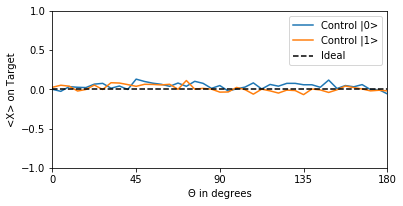

In [87]:
fig, ax = plt.subplots(figsize=(6, 3.2))
plt.plot(thetas, x_vals_control_off, label='Control |0>')
plt.plot(thetas, x_vals_control_on, label='Control |1>')
plt.plot(dense_thetas, [0] * 101, label='Ideal', color='black', linestyle='dashed', linewidth=1.5)
plt.axis([0, 180, -1, 1])
plt.yticks([-1, -.5, 0, .5, 1])
plt.xticks([0, 45, 90, 135, 180])
plt.xlabel('Θ in degrees')
plt.legend()
plt.ylabel('<X> on Target')
plt.gcf().subplots_adjust(bottom=.2)
plt.savefig('Figures/CR_X.svg')

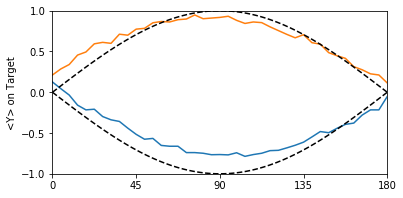

In [88]:
fig, ax = plt.subplots(figsize=(6, 3))
plt.plot(thetas, y_vals_control_off, label='Control |0>')
plt.plot(thetas, y_vals_control_on, label='Control |1>')
plt.plot(dense_thetas, np.sin(dense_thetas*np.pi/180), label='Ideal', color='black', linestyle='dashed', linewidth=1.5)
plt.plot(dense_thetas, -np.sin(dense_thetas*np.pi/180), label='Ideal', color='black', linestyle='dashed', linewidth=1.5)
plt.axis([0, 180, -1, 1])
plt.ylabel('<Y> on Target')
plt.yticks([-1, -.5, 0, .5, 1])
_=plt.xticks([0, 45, 90, 135, 180])
plt.savefig('Figures/CR_Y.svg')

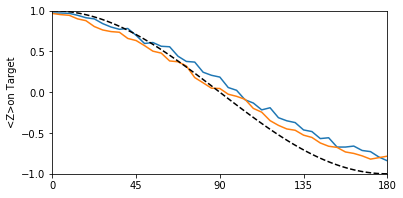

In [78]:
fig, ax = plt.subplots(figsize=(6, 3))
plt.plot(thetas, z_vals_control_off, label='Control |0>')
plt.plot(thetas, z_vals_control_on, label='Control |1>')
plt.plot(dense_thetas, np.cos(dense_thetas*np.pi/180), label='Ideal', color='black', linestyle='dashed', linewidth=1.5)
plt.axis([0, 180, -1, 1])
plt.ylabel('<Z>on Target')
plt.yticks([-1, -.5, 0, .5, 1])
_=plt.xticks([0, 45, 90, 135, 180])
plt.savefig('Figures/CR_Z.svg')